In [1]:
import torch
import torch.cuda as cuda
import torch.nn as nn

from torch.autograd import Variable

from torchvision import datasets
from torchvision import transforms

import torch.nn.functional as F

import matplotlib.pyplot as plt

import numpy as np

import torchvision.models as models

from torch.optim import lr_scheduler

import torch.optim as optim

import os

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224), 0),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224),0),
        transforms.ToTensor(),
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=0, pin_memory=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 2685
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.NEAREST)
               RandomRotation(degrees=(-30, 30), resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [6]:
import torchvision

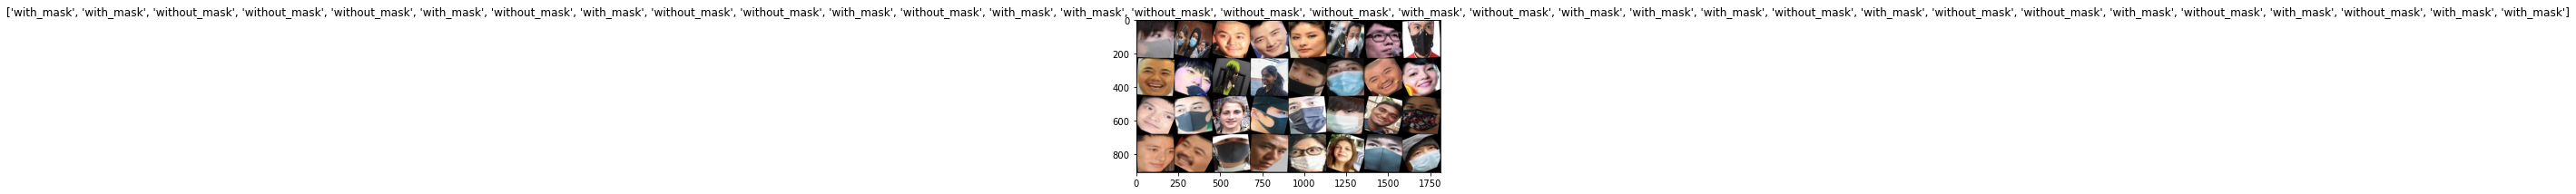

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
import copy, time

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_accuracy.append(epoch_acc)
            else:
                test_loss.append(epoch_loss)
                test_accuracy.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, train_accuracy, test_loss, test_accuracy

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
class CNN_Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        #Input size of the image is 224 x 224 x 3
               
        # NOTE: All Conv2d layers have a default padding of 0 and stride of 1,
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)      # 222 x 222 x 64  (after 1st convolution)
        self.relu1 = nn.ReLU()                            # Same as above
        
        # Convolution Layer 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)     # 220 x 220 x 128  (after 2nd convolution)
        #self.conv2_drop = nn.Dropout2d(p=0.5)            # Dropout is a regularization technqiue we discussed in class
        self.maxpool2 = nn.MaxPool2d(2)                   # 110 x 110 x 128  (after pooling)
        self.relu2 = nn.ReLU()                            # Same as above 
        
        # Convolution Layer 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3)     # 108 x 108 x 256  (after 3nd convolution)
        #self.conv2_drop = nn.Dropout2d(p=0.5)            # Dropout is a regularization technqiue we discussed in class
        self.maxpool3 = nn.MaxPool2d(2)                   # 54 x 54 x 256  (after pooling)
        self.relu3 = nn.ReLU()                            # Same as above 
        
        # Convolution Layer 4
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3)     # 52 x 52 x 512  (after 3nd convolution)
        #self.conv2_drop = nn.Dropout2d(p=0.5)            # Dropout is a regularization technqiue we discussed in class
        self.maxpool4 = nn.MaxPool2d(2)                   # 26 x 26 x 512  (after pooling)
        self.relu4 = nn.ReLU()                            # Same as above 
        
        # Convolution Layer 5
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3)     # 24 x 24 x 1024  (after 3nd convolution)
        #self.conv2_drop = nn.Dropout2d(p=0.5)            # Dropout is a regularization technqiue we discussed in class
        self.maxpool5 = nn.MaxPool2d(2)                   # 12 x 12 x 1024  (after pooling)
        self.relu5 = nn.ReLU()                            # Same as above 
        
        # Fully connected layers
        self.fc1 = nn.Linear(12*12*1024, 50)
        self.fc2 = nn.Linear(50, 2)
 
    def forward(self, x):
        
        # Convolution Layer 1                    
        x = self.conv1(x)                        
        x = self.relu1(x)                        
        
        # Convolution Layer 2
        x = self.conv2(x)               
        #x = self.conv2_drop(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        
        # Convolution Layer 3
        x = self.conv3(x)               
        #x = self.conv2_drop(x)
        x = self.maxpool3(x)
        x = self.relu3(x)
        
        # Convolution Layer 4
        x = self.conv4(x)               
        #x = self.conv2_drop(x)
        x = self.maxpool4(x)
        x = self.relu4(x)
        
        # Convolution Layer 5
        x = self.conv5(x)               
        #x = self.conv2_drop(x)
        x = self.maxpool5(x)
        x = self.relu5(x)
        
        # Switch from activation maps to vectors
        x = x.view(-1, 12*12*1024)
        
        # Fully connected layer 1
        x = self.fc1(x)
        x = F.relu(x)
        #x = F.dropout(x, training=True)
        
        # Fully connected layer 2
        x = self.fc2(x)
        
        return x

In [15]:
model = CNN_Model().to(device)

In [16]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
# model

In [18]:
model, train_loss, train_accuracy, test_loss, test_accuracy = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/opt/conda/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4126 Acc: 0.8063
val Loss: 0.2118 Acc: 0.9260

Epoch 1/24
----------
train Loss: 0.2369 Acc: 0.9181
val Loss: 0.1852 Acc: 0.9294

Epoch 2/24
----------
train Loss: 0.2021 Acc: 0.9285
val Loss: 0.1905 Acc: 0.9260

Epoch 3/24
----------
train Loss: 0.1936 Acc: 0.9251
val Loss: 0.1561 Acc: 0.9364

Epoch 4/24
----------
train Loss: 0.1879 Acc: 0.9270
val Loss: 0.1589 Acc: 0.9512

Epoch 5/24
----------
train Loss: 0.1797 Acc: 0.9348
val Loss: 0.1612 Acc: 0.9338

Epoch 6/24
----------
train Loss: 0.1722 Acc: 0.9408
val Loss: 0.1515 Acc: 0.9373

Epoch 7/24
----------
train Loss: 0.1480 Acc: 0.9430
val Loss: 0.1355 Acc: 0.9469

Epoch 8/24
----------
train Loss: 0.1385 Acc: 0.9490
val Loss: 0.1337 Acc: 0.9434

Epoch 9/24
----------
train Loss: 0.1389 Acc: 0.9460
val Loss: 0.1288 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.1400 Acc: 0.9475
val Loss: 0.1271 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.1350 Acc: 0.9497
val Loss: 0.1268 Acc: 0.9477

Epoch 12/24
----------
t

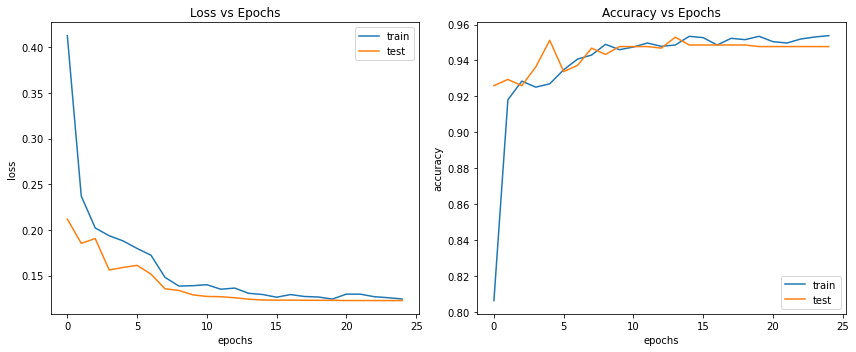

In [19]:
fig, (plt1, plt2) = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(12)

fig.set_tight_layout(True)

plt1.plot(train_loss,label='train')
plt1.plot(test_loss,label='test')

plt2.plot(train_accuracy,label='train')
plt2.plot(test_accuracy,label='test')

plt1.set_title('Loss vs Epochs')
plt1.set_xlabel('epochs')
plt1.set_ylabel('loss')

plt2.set_title('Accuracy vs Epochs')
plt2.set_xlabel('epochs')
plt2.set_ylabel('accuracy')

plt1.legend()
plt2.legend()

plt.show()

In [20]:
fig.savefig('CNN_plots.png')

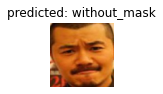

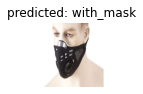

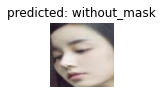

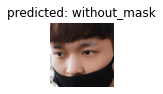

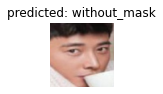

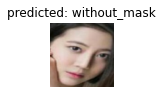

In [21]:
import matplotlib.pyplot as plt

visualize_model(model)

plt.ioff()
plt.show()

In [22]:
PATH = 'trained_cnn.pth'
torch.save(model.state_dict(), PATH)

In [23]:
model1 = models.mobilenet_v2(pretrained=True, progress=True)
num_ftrs = model1.classifier[1].in_features
model1.classifier[1] = nn.Sequential(
                        nn.Linear(num_ftrs, 2),
                        nn.Softmax(-1)
                    )

model1.load_state_dict(torch.load(PATH))
model1.eval()

model1.to(device)

RuntimeError: Error(s) in loading state_dict for MobileNetV2:
	Missing key(s) in state_dict: "features.0.0.weight", "features.0.1.weight", "features.0.1.bias", "features.0.1.running_mean", "features.0.1.running_var", "features.1.conv.0.0.weight", "features.1.conv.0.1.weight", "features.1.conv.0.1.bias", "features.1.conv.0.1.running_mean", "features.1.conv.0.1.running_var", "features.1.conv.1.weight", "features.1.conv.2.weight", "features.1.conv.2.bias", "features.1.conv.2.running_mean", "features.1.conv.2.running_var", "features.2.conv.0.0.weight", "features.2.conv.0.1.weight", "features.2.conv.0.1.bias", "features.2.conv.0.1.running_mean", "features.2.conv.0.1.running_var", "features.2.conv.1.0.weight", "features.2.conv.1.1.weight", "features.2.conv.1.1.bias", "features.2.conv.1.1.running_mean", "features.2.conv.1.1.running_var", "features.2.conv.2.weight", "features.2.conv.3.weight", "features.2.conv.3.bias", "features.2.conv.3.running_mean", "features.2.conv.3.running_var", "features.3.conv.0.0.weight", "features.3.conv.0.1.weight", "features.3.conv.0.1.bias", "features.3.conv.0.1.running_mean", "features.3.conv.0.1.running_var", "features.3.conv.1.0.weight", "features.3.conv.1.1.weight", "features.3.conv.1.1.bias", "features.3.conv.1.1.running_mean", "features.3.conv.1.1.running_var", "features.3.conv.2.weight", "features.3.conv.3.weight", "features.3.conv.3.bias", "features.3.conv.3.running_mean", "features.3.conv.3.running_var", "features.4.conv.0.0.weight", "features.4.conv.0.1.weight", "features.4.conv.0.1.bias", "features.4.conv.0.1.running_mean", "features.4.conv.0.1.running_var", "features.4.conv.1.0.weight", "features.4.conv.1.1.weight", "features.4.conv.1.1.bias", "features.4.conv.1.1.running_mean", "features.4.conv.1.1.running_var", "features.4.conv.2.weight", "features.4.conv.3.weight", "features.4.conv.3.bias", "features.4.conv.3.running_mean", "features.4.conv.3.running_var", "features.5.conv.0.0.weight", "features.5.conv.0.1.weight", "features.5.conv.0.1.bias", "features.5.conv.0.1.running_mean", "features.5.conv.0.1.running_var", "features.5.conv.1.0.weight", "features.5.conv.1.1.weight", "features.5.conv.1.1.bias", "features.5.conv.1.1.running_mean", "features.5.conv.1.1.running_var", "features.5.conv.2.weight", "features.5.conv.3.weight", "features.5.conv.3.bias", "features.5.conv.3.running_mean", "features.5.conv.3.running_var", "features.6.conv.0.0.weight", "features.6.conv.0.1.weight", "features.6.conv.0.1.bias", "features.6.conv.0.1.running_mean", "features.6.conv.0.1.running_var", "features.6.conv.1.0.weight", "features.6.conv.1.1.weight", "features.6.conv.1.1.bias", "features.6.conv.1.1.running_mean", "features.6.conv.1.1.running_var", "features.6.conv.2.weight", "features.6.conv.3.weight", "features.6.conv.3.bias", "features.6.conv.3.running_mean", "features.6.conv.3.running_var", "features.7.conv.0.0.weight", "features.7.conv.0.1.weight", "features.7.conv.0.1.bias", "features.7.conv.0.1.running_mean", "features.7.conv.0.1.running_var", "features.7.conv.1.0.weight", "features.7.conv.1.1.weight", "features.7.conv.1.1.bias", "features.7.conv.1.1.running_mean", "features.7.conv.1.1.running_var", "features.7.conv.2.weight", "features.7.conv.3.weight", "features.7.conv.3.bias", "features.7.conv.3.running_mean", "features.7.conv.3.running_var", "features.8.conv.0.0.weight", "features.8.conv.0.1.weight", "features.8.conv.0.1.bias", "features.8.conv.0.1.running_mean", "features.8.conv.0.1.running_var", "features.8.conv.1.0.weight", "features.8.conv.1.1.weight", "features.8.conv.1.1.bias", "features.8.conv.1.1.running_mean", "features.8.conv.1.1.running_var", "features.8.conv.2.weight", "features.8.conv.3.weight", "features.8.conv.3.bias", "features.8.conv.3.running_mean", "features.8.conv.3.running_var", "features.9.conv.0.0.weight", "features.9.conv.0.1.weight", "features.9.conv.0.1.bias", "features.9.conv.0.1.running_mean", "features.9.conv.0.1.running_var", "features.9.conv.1.0.weight", "features.9.conv.1.1.weight", "features.9.conv.1.1.bias", "features.9.conv.1.1.running_mean", "features.9.conv.1.1.running_var", "features.9.conv.2.weight", "features.9.conv.3.weight", "features.9.conv.3.bias", "features.9.conv.3.running_mean", "features.9.conv.3.running_var", "features.10.conv.0.0.weight", "features.10.conv.0.1.weight", "features.10.conv.0.1.bias", "features.10.conv.0.1.running_mean", "features.10.conv.0.1.running_var", "features.10.conv.1.0.weight", "features.10.conv.1.1.weight", "features.10.conv.1.1.bias", "features.10.conv.1.1.running_mean", "features.10.conv.1.1.running_var", "features.10.conv.2.weight", "features.10.conv.3.weight", "features.10.conv.3.bias", "features.10.conv.3.running_mean", "features.10.conv.3.running_var", "features.11.conv.0.0.weight", "features.11.conv.0.1.weight", "features.11.conv.0.1.bias", "features.11.conv.0.1.running_mean", "features.11.conv.0.1.running_var", "features.11.conv.1.0.weight", "features.11.conv.1.1.weight", "features.11.conv.1.1.bias", "features.11.conv.1.1.running_mean", "features.11.conv.1.1.running_var", "features.11.conv.2.weight", "features.11.conv.3.weight", "features.11.conv.3.bias", "features.11.conv.3.running_mean", "features.11.conv.3.running_var", "features.12.conv.0.0.weight", "features.12.conv.0.1.weight", "features.12.conv.0.1.bias", "features.12.conv.0.1.running_mean", "features.12.conv.0.1.running_var", "features.12.conv.1.0.weight", "features.12.conv.1.1.weight", "features.12.conv.1.1.bias", "features.12.conv.1.1.running_mean", "features.12.conv.1.1.running_var", "features.12.conv.2.weight", "features.12.conv.3.weight", "features.12.conv.3.bias", "features.12.conv.3.running_mean", "features.12.conv.3.running_var", "features.13.conv.0.0.weight", "features.13.conv.0.1.weight", "features.13.conv.0.1.bias", "features.13.conv.0.1.running_mean", "features.13.conv.0.1.running_var", "features.13.conv.1.0.weight", "features.13.conv.1.1.weight", "features.13.conv.1.1.bias", "features.13.conv.1.1.running_mean", "features.13.conv.1.1.running_var", "features.13.conv.2.weight", "features.13.conv.3.weight", "features.13.conv.3.bias", "features.13.conv.3.running_mean", "features.13.conv.3.running_var", "features.14.conv.0.0.weight", "features.14.conv.0.1.weight", "features.14.conv.0.1.bias", "features.14.conv.0.1.running_mean", "features.14.conv.0.1.running_var", "features.14.conv.1.0.weight", "features.14.conv.1.1.weight", "features.14.conv.1.1.bias", "features.14.conv.1.1.running_mean", "features.14.conv.1.1.running_var", "features.14.conv.2.weight", "features.14.conv.3.weight", "features.14.conv.3.bias", "features.14.conv.3.running_mean", "features.14.conv.3.running_var", "features.15.conv.0.0.weight", "features.15.conv.0.1.weight", "features.15.conv.0.1.bias", "features.15.conv.0.1.running_mean", "features.15.conv.0.1.running_var", "features.15.conv.1.0.weight", "features.15.conv.1.1.weight", "features.15.conv.1.1.bias", "features.15.conv.1.1.running_mean", "features.15.conv.1.1.running_var", "features.15.conv.2.weight", "features.15.conv.3.weight", "features.15.conv.3.bias", "features.15.conv.3.running_mean", "features.15.conv.3.running_var", "features.16.conv.0.0.weight", "features.16.conv.0.1.weight", "features.16.conv.0.1.bias", "features.16.conv.0.1.running_mean", "features.16.conv.0.1.running_var", "features.16.conv.1.0.weight", "features.16.conv.1.1.weight", "features.16.conv.1.1.bias", "features.16.conv.1.1.running_mean", "features.16.conv.1.1.running_var", "features.16.conv.2.weight", "features.16.conv.3.weight", "features.16.conv.3.bias", "features.16.conv.3.running_mean", "features.16.conv.3.running_var", "features.17.conv.0.0.weight", "features.17.conv.0.1.weight", "features.17.conv.0.1.bias", "features.17.conv.0.1.running_mean", "features.17.conv.0.1.running_var", "features.17.conv.1.0.weight", "features.17.conv.1.1.weight", "features.17.conv.1.1.bias", "features.17.conv.1.1.running_mean", "features.17.conv.1.1.running_var", "features.17.conv.2.weight", "features.17.conv.3.weight", "features.17.conv.3.bias", "features.17.conv.3.running_mean", "features.17.conv.3.running_var", "features.18.0.weight", "features.18.1.weight", "features.18.1.bias", "features.18.1.running_mean", "features.18.1.running_var", "classifier.1.0.weight", "classifier.1.0.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "conv3.weight", "conv3.bias", "conv4.weight", "conv4.bias", "conv5.weight", "conv5.bias", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 

In [ ]:
visualize_model(model1)

plt.ioff()
plt.show()

In [ ]:
# import glob, shutil

# with_mask = glob.glob('dataset/with_mask/*')
# without_mask = glob.glob('dataset/without_mask/*')

# len_data = len(with_mask)

# split = .3

# len_data*split

# import random, os

# test_with_mask = random.sample(with_mask, int(len_data*split))
# test_without_mask = random.sample(without_mask, int(len_data*split))

# os.mkdir('val')
# os.mkdir('val/with_mask')
# os.mkdir('val/without_mask')

# for i in range(len(test_with_mask)):
#     shutil.move(test_with_mask[i], 'val/with_mask')
#     shutil.move(test_without_mask[i], 'val/without_mask')    

In [24]:
from torchsummary import summary

summary(model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 222, 222]        1,792
├─ReLU: 1-2                              [-1, 64, 222, 222]        --
├─Conv2d: 1-3                            [-1, 128, 220, 220]       73,856
├─MaxPool2d: 1-4                         [-1, 128, 110, 110]       --
├─ReLU: 1-5                              [-1, 128, 110, 110]       --
├─Conv2d: 1-6                            [-1, 256, 108, 108]       295,168
├─MaxPool2d: 1-7                         [-1, 256, 54, 54]         --
├─ReLU: 1-8                              [-1, 256, 54, 54]         --
├─Conv2d: 1-9                            [-1, 512, 52, 52]         1,180,160
├─MaxPool2d: 1-10                        [-1, 512, 26, 26]         --
├─ReLU: 1-11                             [-1, 512, 26, 26]         --
├─Conv2d: 1-12                           [-1, 1024, 24, 24]        4,719,616
├─MaxPool2d: 1-13                        [-1, 1024, 12, 12]

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 222, 222]        1,792
├─ReLU: 1-2                              [-1, 64, 222, 222]        --
├─Conv2d: 1-3                            [-1, 128, 220, 220]       73,856
├─MaxPool2d: 1-4                         [-1, 128, 110, 110]       --
├─ReLU: 1-5                              [-1, 128, 110, 110]       --
├─Conv2d: 1-6                            [-1, 256, 108, 108]       295,168
├─MaxPool2d: 1-7                         [-1, 256, 54, 54]         --
├─ReLU: 1-8                              [-1, 256, 54, 54]         --
├─Conv2d: 1-9                            [-1, 512, 52, 52]         1,180,160
├─MaxPool2d: 1-10                        [-1, 512, 26, 26]         --
├─ReLU: 1-11                             [-1, 512, 26, 26]         --
├─Conv2d: 1-12                           [-1, 1024, 24, 24]        4,719,616
├─MaxPool2d: 1-13                        [-1, 1024, 12, 12]